In [1]:
import torch
import torch.nn as nn

from gsp_utils.data import get_data_dgl, pert_S

from arch.model import RobustGNNModel1, RobustGNNModel2

import numpy as np

import matplotlib.pyplot as plt

from utils import GCNN, GAT, MLP, GCNH, test_gcnh

from networkx import from_numpy_array
from dgl import from_networkx

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
assert torch.cuda.is_available()

# Single dataset test

In [3]:
dataset = "CornellDataset"
dataset = "CoraGraphDataset"

S, feat, labels, n_class, masks = get_data_dgl(dataset, dev=device)
print("Nodes", S.shape[0])

Nodes 2708


In [4]:
n_iters_H = 50
n_epochs = 500
lr = 0.001
wd = 1e-2
eval_freq = 1
es_patience_gcnh = 100
es_patience_rgcnh = 20

lr_S = 1e-3

n_iters = 100
n_iters_S = 10#15

hid_dim = 32
n_layers = 2
bias = True
dropout = 0.25
K = 3
norm_S = True
act = nn.LeakyReLU
batch_norm = False

in_dim = feat.shape[1]
out_dim = n_class

model_params = {
    'in_dim': in_dim,
    'hid_dim': hid_dim,
    'out_dim': out_dim,
    'n_layers': n_layers,
    'act': act,
    'bias': bias,
    'last_act': nn.Softmax(dim=1),
    'dropout': dropout,
    'K': K,
    'norm_S': norm_S,
    'batch_norm': batch_norm
}
model_params_m2 = model_params.copy()
del model_params_m2['K']
del model_params_m2['norm_S']

gamma = 0
beta = 0.1
lambd = 1.

hid_dim_gat = 8
num_heads = 8
gat_params = {
    'feat_drop': 0.6,
    'attn_drop': 0.6
}

In [5]:
eps = 0.0
Sn = pert_S(S, type="rewire_nonsym", eps=eps)
g = from_networkx(from_numpy_array(Sn)).add_self_loop().to(device)

S = torch.Tensor(S).to(device)
Sn = torch.Tensor(Sn).to(device)

torch.linalg.norm(Sn/torch.linalg.norm(Sn) - S / torch.linalg.norm(S))

tensor(0., device='cuda:0')

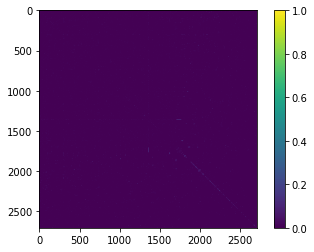

In [6]:
plt.imshow(S.to('cpu').numpy())
plt.colorbar()

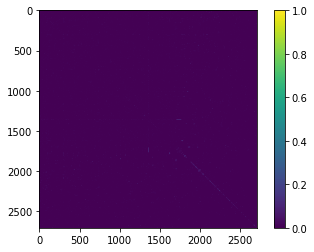

In [7]:
plt.imshow(Sn.to('cpu').numpy())
plt.colorbar()

In [8]:
S_init = Sn.clone()#torch.zeros(Sn.shape, device=device)
model = RobustGNNModel1(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
model.model = model.model.to(device)

results_dict_m1, S_dict_m1 = model.test_model(Sn, feat, labels, gamma, lambd, beta, train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'], norm_S=False, S_true=S, es_patience=es_patience_rgcnh, verbose=True, debug_S=False)

Iteration 1 DONE - Acc Test: 0.168 - Err S: 0.7844294905662537
Iteration 2 DONE - Acc Test: 0.149 - Err S: 0.7746163606643677
Iteration 3 DONE - Acc Test: 0.155 - Err S: 0.7648065686225891
Iteration 4 DONE - Acc Test: 0.179 - Err S: 0.7550003528594971
Iteration 5 DONE - Acc Test: 0.091 - Err S: 0.7451977729797363
Iteration 6 DONE - Acc Test: 0.091 - Err S: 0.7353989481925964
Iteration 7 DONE - Acc Test: 0.091 - Err S: 0.7256038784980774
Iteration 8 DONE - Acc Test: 0.091 - Err S: 0.7158128619194031
Iteration 9 DONE - Acc Test: 0.096 - Err S: 0.7060260772705078
Iteration 10 DONE - Acc Test: 0.216 - Err S: 0.696243405342102
Iteration 11 DONE - Acc Test: 0.22 - Err S: 0.6864655613899231
Iteration 12 DONE - Acc Test: 0.334 - Err S: 0.6766922473907471
Iteration 13 DONE - Acc Test: 0.342 - Err S: 0.6669241786003113
Iteration 14 DONE - Acc Test: 0.344 - Err S: 0.6571615934371948
Iteration 15 DONE - Acc Test: 0.346 - Err S: 0.6474045515060425
Iteration 16 DONE - Acc Test: 0.347 - Err S: 0.6376

In [9]:
results_dict_m1['best_acc_test'], model.eval_fn(feat, labels, masks['test']), model.eval_fn(feat, labels, masks['train'])

(0.719, 0.711, 0.9642857142857143)

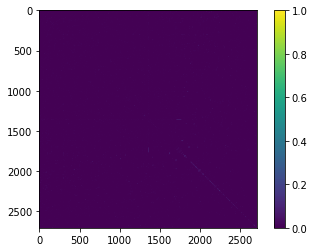

In [10]:
plt.imshow(S_dict_m1['rec_S'].cpu().numpy())
plt.colorbar()

In [11]:
torch.linalg.norm(S_dict_m1['rec_S']), torch.linalg.norm(S)

(tensor(91.0346, device='cuda:0'), tensor(102.7424, device='cuda:0'))

In [12]:
S_init = Sn.clone()#torch.zeros(Sn.shape, device=device)
model = RobustGNNModel2(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params_m2, n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
model.model = model.model.to(device)

results_dict_m2, S_dict_m2 = model.test_model(Sn, feat, labels, gamma, lambd, beta, train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'], norm_S=False, S_true=S, es_patience=es_patience_rgcnh, verbose=True, debug_S=False)

Iteration 1 DONE - Acc Test: 0.25 - Err S: 0.0
Iteration 2 DONE - Acc Test: 0.266 - Err S: 0.0
Iteration 3 DONE - Acc Test: 0.271 - Err S: 0.0
Iteration 4 DONE - Acc Test: 0.288 - Err S: 0.0
Iteration 5 DONE - Acc Test: 0.293 - Err S: 0.0
Iteration 6 DONE - Acc Test: 0.289 - Err S: 0.0
Iteration 7 DONE - Acc Test: 0.287 - Err S: 0.0
Iteration 8 DONE - Acc Test: 0.258 - Err S: 0.0
Iteration 9 DONE - Acc Test: 0.253 - Err S: 0.0
Iteration 10 DONE - Acc Test: 0.255 - Err S: 0.0
Iteration 11 DONE - Acc Test: 0.256 - Err S: 0.0
Iteration 12 DONE - Acc Test: 0.252 - Err S: 0.0
Iteration 13 DONE - Acc Test: 0.285 - Err S: 0.0
Iteration 14 DONE - Acc Test: 0.302 - Err S: 0.0
Iteration 15 DONE - Acc Test: 0.321 - Err S: 0.0
Iteration 16 DONE - Acc Test: 0.335 - Err S: 0.0
Iteration 17 DONE - Acc Test: 0.333 - Err S: 0.0
Iteration 18 DONE - Acc Test: 0.322 - Err S: 0.0
Iteration 19 DONE - Acc Test: 0.325 - Err S: 0.0
Iteration 20 DONE - Acc Test: 0.313 - Err S: 0.0
Iteration 21 DONE - Acc Test: 

In [13]:
n_iters_H_gnn = 50
model = RobustGNNModel1(Sn, n_iters_H_gnn, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
model.model = model.model.to(device)

_, _, acc_test, _ = model.stepH(
    feat, labels, masks['train'], masks['val'], masks['test'], verbose=True
)

	Epoch (H) 1/50 - Loss: -0.143 - Train Acc: 0.264 - Test Acc: 0.210
	Epoch (H) 2/50 - Loss: -0.143 - Train Acc: 0.264 - Test Acc: 0.172
	Epoch (H) 3/50 - Loss: -0.143 - Train Acc: 0.300 - Test Acc: 0.197
	Epoch (H) 4/50 - Loss: -0.143 - Train Acc: 0.350 - Test Acc: 0.295
	Epoch (H) 5/50 - Loss: -0.143 - Train Acc: 0.443 - Test Acc: 0.423
	Epoch (H) 6/50 - Loss: -0.143 - Train Acc: 0.464 - Test Acc: 0.462
	Epoch (H) 7/50 - Loss: -0.143 - Train Acc: 0.507 - Test Acc: 0.471
	Epoch (H) 8/50 - Loss: -0.143 - Train Acc: 0.557 - Test Acc: 0.446
	Epoch (H) 9/50 - Loss: -0.144 - Train Acc: 0.543 - Test Acc: 0.387
	Epoch (H) 10/50 - Loss: -0.144 - Train Acc: 0.529 - Test Acc: 0.365
	Epoch (H) 11/50 - Loss: -0.144 - Train Acc: 0.521 - Test Acc: 0.342
	Epoch (H) 12/50 - Loss: -0.144 - Train Acc: 0.521 - Test Acc: 0.328
	Epoch (H) 13/50 - Loss: -0.144 - Train Acc: 0.507 - Test Acc: 0.308
	Epoch (H) 14/50 - Loss: -0.144 - Train Acc: 0.507 - Test Acc: 0.307
	Epoch (H) 15/50 - Loss: -0.144 - Train Acc

In [14]:
#model = GCNH(torch.zeros(Sn.shape, device=device), in_dim, hid_dim, out_dim, model_params['K'], dropout=model_params['dropout']).to(device)
model = GCNH(Sn.clone(), **model_params).to(device)

# model training
loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, True)
best_acc_test

Epoch 1/500 - Loss Train: 1.9458688497543335 - Acc Train: 0.44999998807907104 - Acc Val: 0.29 - Acc Test: 0.3050000071525574
Epoch 4/500 - Loss Train: 1.9406070709228516 - Acc Train: 0.9642857313156128 - Acc Val: 0.606 - Acc Test: 0.6140000224113464
Epoch 8/500 - Loss Train: 1.9322770833969116 - Acc Train: 0.9714285731315613 - Acc Val: 0.698 - Acc Test: 0.7390000224113464
Epoch 12/500 - Loss Train: 1.9238388538360596 - Acc Train: 0.9785714149475098 - Acc Val: 0.736 - Acc Test: 0.7649999856948853
Epoch 16/500 - Loss Train: 1.916321039199829 - Acc Train: 0.9785714149475098 - Acc Val: 0.708 - Acc Test: 0.7329999804496765
Epoch 20/500 - Loss Train: 1.9095478057861328 - Acc Train: 0.9785714149475098 - Acc Val: 0.696 - Acc Test: 0.7210000157356262
Epoch 24/500 - Loss Train: 1.9038004875183105 - Acc Train: 0.9714285731315613 - Acc Val: 0.718 - Acc Test: 0.7319999933242798
Epoch 28/500 - Loss Train: 1.8983803987503052 - Acc Train: 0.9714285731315613 - Acc Val: 0.716 - Acc Test: 0.7390000224113

0.765

In [15]:
#model = GCNH(torch.zeros(Sn.shape, device=device), in_dim, hid_dim, out_dim, model_params['K'], dropout=model_params['dropout']).to(device)
model = MLP(in_dim, hid_dim, out_dim, dropout=model_params['dropout']).to(device)

# model training
loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, True)

Epoch 1/500 - Loss Train: 1.948250412940979 - Acc Train: 0.1428571492433548 - Acc Val: 0.162 - Acc Test: 0.1469999998807907
Epoch 4/500 - Loss Train: 1.9470428228378296 - Acc Train: 0.1428571492433548 - Acc Val: 0.162 - Acc Test: 0.14900000393390656
Epoch 8/500 - Loss Train: 1.945164442062378 - Acc Train: 0.16428571939468384 - Acc Val: 0.164 - Acc Test: 0.1509999930858612
Epoch 12/500 - Loss Train: 1.9437763690948486 - Acc Train: 0.17142857611179352 - Acc Val: 0.166 - Acc Test: 0.15299999713897705
Epoch 16/500 - Loss Train: 1.9424667358398438 - Acc Train: 0.1785714328289032 - Acc Val: 0.166 - Acc Test: 0.15299999713897705
Epoch 20/500 - Loss Train: 1.9414618015289307 - Acc Train: 0.22142857313156128 - Acc Val: 0.172 - Acc Test: 0.15399999916553497
Epoch 24/500 - Loss Train: 1.9407761096954346 - Acc Train: 0.25 - Acc Val: 0.174 - Acc Test: 0.15800000727176666
Epoch 28/500 - Loss Train: 1.9393352270126343 - Acc Train: 0.27142858505249023 - Acc Val: 0.174 - Acc Test: 0.1679999977350235
Ep

## Pro-GNN

# Exhaustive Tests

In [16]:
EXPS = [
    {
        "dataset": "Cornell",
        "layer": "GCNH",
        "legend": "Cornell-GCNH",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "GCNH",
        "legend": "Texas-GCNH",
        "fmt": "d-"
    },
    {
        "dataset": "Wisconsin",
        "layer": "GCNH",
        "legend": "Wisconsin-GCNH",
        "fmt": "s-"
    },
    {
        "dataset": "CoraGraph",
        "layer": "GCNH",
        "legend": "Cora-GCNH",
        "fmt": "o-"
    },
    {
        "dataset": "Cornell",
        "layer": "RGFGCN-M1",
        "legend": "Cornell-RGCNH-M1",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "RGFGCN-M1",
        "legend": "Texas-RGCNH-M1",
        "fmt": "d-"
    },
    {
        "dataset": "Wisconsin",
        "layer": "RGFGCN-M1",
        "legend": "Wisconsin-RGCNH-M1",
        "fmt": "s-"
    },
    {
        "dataset": "CoraGraph",
        "layer": "RGFGCN-M1",
        "legend": "Cora-RGCNH-M1",
        "fmt": "o-"
    },
#     {
#         "dataset": "Cornell",
#         "layer": "RGFGCN-M2",
#         "legend": "Cornell-RGCNH-M2",
#         "fmt": "v-"
#     },
#     {
#         "dataset": "Texas",
#         "layer": "RGFGCN-M2",
#         "legend": "Texas-RGCNH-M2",
#         "fmt": "d-"
#     },
#     {
#         "dataset": "Wisconsin",
#         "layer": "RGFGCN-M2",
#         "legend": "Wisconsin-RGCNH-M2",
#         "fmt": "s-"
#     },
#     {
#         "dataset": "CoraGraph",
#         "layer": "RGFGCN-M2",
#         "legend": "Cora-RGCNH-M2",
#         "fmt": "o-"
#     },
    {
        "dataset": "Cornell",
        "layer": "GCNN",
        "legend": "Cornell-GCNN",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "GCNN",
        "legend": "Texas-GCNN",
        "fmt": "d-"
    },
    {
        "dataset": "Wisconsin",
        "layer": "GCNN",
        "legend": "Wisconsin-GCNN",
        "fmt": "s-"
    },
    {
        "dataset": "CoraGraph",
        "layer": "GCNN",
        "legend": "Cora-GCNN",
        "fmt": "o-"
    },
#     {
#         "dataset": "Cornell",
#         "layer": "ProGNN",
#         "legend": "Cornell-ProGNN",
#         "fmt": "v-"
#     },
#     {
#         "dataset": "Texas",
#         "layer": "ProGNN",
#         "legend": "Texas-ProGNN",
#         "fmt": "d-"
#     },
#     {
#         "dataset": "Wisconsin",
#         "layer": "ProGNN",
#         "legend": "Wisconsin-ProGNN",
#         "fmt": "s-"
#     },
#     {
#         "dataset": "CoraGraph",
#         "layer": "ProGNN",
#         "legend": "Cora-ProGNN",
#         "fmt": "o-"
#     },
    {
        "dataset": "Cornell",
        "layer": "GAT",
        "legend": "Cornell-GAT",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "GAT",
        "legend": "Texas-GAT",
        "fmt": "d-"
    },
    {
        "dataset": "Wisconsin",
        "layer": "GAT",
        "legend": "Wisconsin-GAT",
        "fmt": "s-"
    },
    {
        "dataset": "CoraGraph",
        "layer": "GAT",
        "legend": "Cora-GAT",
        "fmt": "o-"
    },
    # {
    #     "dataset": "Cornell",
    #     "layer": "MLP",
    #     "legend": "Cornell-MLP",
    #     "fmt": "v-."
    # },
    # {
    #     "dataset": "Texas",
    #     "layer": "MLP",
    #     "legend": "Texas-MLP",
    #     "fmt": "d-."
    # },
    # {
    #     "dataset": "Wisconsin",
    #     "layer": "MLP",
    #     "legend": "Wisconsin-MLP",
    #     "fmt": "s-."
    # },
]

In [17]:
# EXPS = [
#     {
#         "dataset": "CoraGraph",
#         "layer": "GCNH",
#         "legend": "Cora-GCNH",
#         "fmt": "o-"
#     },
#     {
#         "dataset": "Texas",
#         "layer": "RGFGCN-M2",
#         "legend": "Texas-RGCNH-M2",
#         "fmt": "d-"
#     },
# ]

In [ ]:
#perts = [0., 0.01, 0.02, 0.05, 0.15]
perts = [0., 0.01, 0.02, 0.05, 0.1, 0.15, 0.25, 0.5]

n_graphs = 30
n_graphs_cora = 3

accs_test = np.zeros((n_graphs, len(EXPS), len(perts)))
errs_S = np.zeros((n_graphs, len(EXPS), len(perts)))
for i, p in enumerate(perts):

    for j, exp in enumerate(EXPS):

        print(f"Starting pert {p} of exp {exp['dataset']} - {exp['layer']}: ", end="")

        if "Cora" in exp['dataset']:
            n_graphs_exp = n_graphs_cora
        else:
            n_graphs_exp = n_graphs

        for n in range(n_graphs_exp):

            #if exp['dataset'] == "Cornell" or exp['dataset'] == "Texas" or exp['dataset'] == "Wisconsin": # TODO: Implement cross validation properly
            idx = n % 10
            S, feat, labels, n_class, masks = get_data_dgl(exp['dataset'] + "Dataset", dev=device, idx=idx)
            
            in_dim = feat.shape[1]
            out_dim = n_class
            model_params['in_dim'] = in_dim
            model_params['out_dim'] = out_dim
            model_params_m2['in_dim'] = in_dim
            model_params_m2['out_dim'] = out_dim
                
            print(f"{n+1} ", end="")
            
            Sn = pert_S(S.copy(), type="rewire_nonsym", eps=p)
            if p == 0.:
                assert np.all(Sn == S)

            g = from_networkx(from_numpy_array(Sn.copy())).add_self_loop().to(device)

            S = torch.Tensor(S).to(device)
            Sn = torch.Tensor(Sn).to(device)
            if p == 0.:
                assert torch.all(Sn == S)

            if exp['layer'] == "GCNH":
                # model.n_iters_H = 50
                # _, _, acc_test, _ = model.stepH(
                #     feat, labels, masks['train'], masks['val'], masks['test'], verbose=False
                # )
                model = GCNH(Sn.clone(), **model_params).to(device)
                
                # model training
                loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, False)
                err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
            elif exp['layer'] == "RGFGCN-M1":
                #S_init = torch.zeros(S.shape, device=device)
                S_init = Sn.clone()
                model = RobustGNNModel1(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params,
                                        n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
                model.model = model.model.to(device)
                results_dict, S_dict = model.test_model(Sn, feat, labels, gamma, lambd, beta,
                                                            train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'],
                                                            norm_S=False, S_true=S, es_patience=es_patience_rgcnh, verbose=False
                                                       )
                best_acc_test = results_dict['best_acc_test']
                best_acc_val = results_dict['best_acc_val']
                err_S = S_dict['best_err_S']
            elif exp['layer'] == "RGFGCN-M2":
                #S_init = torch.zeros(S.shape, device=device)
                S_init = Sn.clone()
                model = RobustGNNModel2(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params_m2,
                                        n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
                model.model = model.model.to(device)
                results_dict, S_dict = model.test_model(Sn, feat, labels, gamma, lambd, beta,
                                                            train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'],
                                                            norm_S=False, S_true=S, es_patience=es_patience_rgcnh, verbose=False
                                                       )
                best_acc_test = results_dict['best_acc_test']
                best_acc_val = results_dict['best_acc_val']
                err_S = S_dict['best_err_S']
            elif exp['layer'] == "MLP":
                model = MLP(in_dim, hid_dim, out_dim).to(device)

                # model training
                loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, False)
                err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)

            elif exp['layer'] == "GCNN":
                model = GCNN(in_dim, hid_dim, out_dim).to(device)

                # model training
                loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, False)
                err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
            elif exp['layer'] == "GAT":
                model = GAT(in_dim, hid_dim_gat, out_dim, num_heads, gat_params).to(device)

                # model training
                loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, False)
                err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
            elif exp['layer'] == "ProGNN":
                model = GCN(nfeat=in_dim,
                            nhid=hid_dim,
                            nclass=n_class,
                            dropout=0.5, device=device)

                prognn = ProGNN(model, prognn_args, device)
                prognn.fit(feat, Sn, labels, masks['train'], masks['val'])
                best_acc_test = prognn.test(feat, labels, masks['test'])
                err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
            #print(acc_test[-1], end=" ")
            accs_test[n, j, i] = best_acc_test
            errs_S[n, j, i] = err_S
        print(f"DONE - Accuracy Test: {np.mean(accs_test[:n_graphs_exp,:,:], 0)[j,i]:.5f}")

Starting pert 0.0 of exp Cornell - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.69550
Starting pert 0.0 of exp Texas - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.76577
Starting pert 0.0 of exp Wisconsin - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.76013
Starting pert 0.0 of exp CoraGraph - GCNH: 1 2 3 DONE - Accuracy Test: 0.77000
Starting pert 0.0 of exp Cornell - RGFGCN-M1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.70541
Starting pert 0.0 of exp Texas - RGFGCN-M1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.78649
Starting pert 0.0 of exp Wisconsin - RGFGCN-M1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.

In [ ]:
for i, exp in enumerate(EXPS):
    plt.plot(perts, accs_test[:n_graphs_cora if "Cora" in exp['dataset'] else n_graphs,:,:].mean(0)[i,:], exp["fmt"], label=exp["legend"])

plt.xlabel("Percentage of links modified", fontsize=12)
plt.ylabel("Accuracy over the test dataset", fontsize=12)
plt.title("Effect of perturbations on the performance of a GNN", fontsize=16)
plt.legend()
plt.grid()

In [ ]:
np.mean(accs_test, 0)[0,0], np.mean(accs_test, 0)[4,0]

In [ ]:
datasets = ["Cornell", "Texas", "Wisconsin", "CoraGraph"]

f, ax = plt.subplots(1,len(datasets), figsize=(12,6))

for i, exp in enumerate(EXPS):
    idx = datasets.index(exp["dataset"])
    if i == 4:
        print(accs_test[:n_graphs_cora if "Cora" in exp['dataset'] else n_graphs,:,:].mean(0)[i,:])
    ax[idx].plot(perts, accs_test[:n_graphs_cora if "Cora" in exp['dataset'] else n_graphs,:,:].mean(0)[i,:], exp["fmt"], label=exp["legend"])

for i, d in enumerate(datasets):
    ax[i].set_title(d)
    ax[i].set_xlabel("Percentage of links modified")

f.legend()

In [ ]:
if True:
    with open('results/20231124-perts.csv', 'w') as f:
        f.write("Pert;" + ';'.join([exp['legend'] for exp in EXPS]) + "\n")
        for i in range(len(perts)):
            f.write(str(perts[i]) + ';' + ';'.join([str(accs_test[:n_graphs_cora if "Cora" in EXPS[j]['dataset'] else n_graphs,:,:].mean(0)[j,i]) for j in range(len(EXPS))]) + '\n')

In [ ]:
for i, exp in enumerate(EXPS):
    plt.plot(perts, errs_S.mean(0)[i,:], exp["fmt"], label=exp["legend"])

plt.xlabel("Percentage of links modified", fontsize=12)
plt.ylabel("Error on the recovered S", fontsize=12)
plt.title("Effect of perturbations on the graph denoising", fontsize=16)
plt.legend()
plt.grid()